In [1]:
import numpy as np
import pandas as pd

import pathlib

import pickle

import os
import sys

import math
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

import torch


In [2]:
sys.path.insert(0, "../src")

In [3]:
from custom_distance import KL

# SHAC Results

In [4]:
!ls -l ../output/

total 44
drwxr-xr-x  3 xiruod domain users 4096 May 10 21:58 LLaMaEmbeddings
drwxrwxr-x  3 xiruod xiruod_local 4096 Dec  1  2022 output.small
drwxr-xr-x  2 xiruod domain users 4096 Mar 18 05:50 regressionInverseSHAC_MIMIC_UW
drwxr-xr-x  3 xiruod domain users 4096 May 13 21:00 regressionSHAC
drwxrwxr-x 10 xiruod xiruod_local 4096 Dec  3  2022 step101_runExp
drwxrwxr-x 14 xiruod xiruod_local 4096 Feb  3 03:26 step102_runExp_TwoHeads
drwxr-xr-x  4 xiruod domain users 4096 Mar  9 07:08 step102_runExp_TwoHeads_SHAC
drwxrwxr-x  6 xiruod xiruod_local 4096 Jan 11  2023 step103_runExp_SingleLabel
drwxr-xr-x  5 xiruod domain users 4096 Jul 13 23:30 step103_runExp_SingleLabel_SHAC
drwxr-xr-x  4 xiruod domain users 4096 May  4 22:36 step104_runExp_backdoorBERT_SHAC
drwxr-xr-x  3 xiruod domain users 4096 May  9 10:22 step105_runExp_SingleLabel_UID_SHAC


In [52]:
!ls -l ../output/step103_runExp_SingleLabel_SHAC/

total 152
drwxr-xr-x 204 xiruod domain users 77824 Mar  8 06:42 exp_SingleHead_SHAC_05_02
drwxr-xr-x 213 xiruod domain users 69632 May  4 10:39 exp_SingleHead_SHAC_n500_05_02


In [5]:
!ls -l ../output/step103_runExp_SingleLabel_SHAC/

total 224
drwxr-xr-x 204 xiruod domain users 77824 Mar  8 06:42 exp_SingleHead_SHAC_05_02
drwxr-xr-x 213 xiruod domain users 69632 Jul 14 11:14 exp_SingleHead_SHAC_ClinicalBERT_n500_05_02
drwxr-xr-x 213 xiruod domain users 69632 May  4 10:39 exp_SingleHead_SHAC_n500_05_02


In [ ]:
# path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_05_1/"]
# y_pred_file = "y_pred.csv"
# y_prob_file = "y_prob.csv"

# path_results = ["../output/step102_runExp_TwoHeads_SHAC/exp_TwoHeads_SHAC_05_02/"]
# y_pred_file = "y_main_pred.csv"
# y_prob_file = "y_main_prob.csv"


# path_results = ["../output/step102_runExp_TwoHeads_SHAC/exp_GradientReversal_SHAC_05_02/"]
# y_pred_file = "y_main_pred.csv"
# y_prob_file = "y_main_prob.csv"

path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_n500_05_02/"]
y_pred_file = "y_pred.csv"
y_prob_file = "y_prob.csv"


In [10]:
path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_ClinicalBERT_n500_05_02/"]
y_pred_file = "y_pred.csv"
y_prob_file = "y_prob.csv"
y_test_file = "y_test.csv"


In [ ]:

path_results = ["../output/step104_runExp_backdoorBERT_SHAC/exp_backdoorBERT_SHAC_n500_05_02_v1/"]
y_pred_file = None
y_prob_file = "y_main_prob.csv"
y_test_file = "y_test.csv"

In [12]:

path_results = ["../output/step105_runExp_SingleLabel_UID_SHAC/exp_SingleHead_UID_SHAC_n500_05_02/"]
y_pred_file = None
y_prob_file = "y_prob.csv"
y_test_file = "y_test.csv"

In [7]:
def collectResults(path_results, y_prob_file, y_test_file, y_pred_file=None):
    

    df_ls = []

    loss = torch.nn.NLLLoss()
    for path_i in pathlib.Path(path_results[0]).glob("setting*"):

        with open(pathlib.Path(path_i, "full_settings.pkl"), "rb") as f:
            full_setting_i = pickle.load(f)

        for rand_i in path_i.glob("RandomRun_*"):


            num_i = os.path.basename(rand_i).split("_")[1]
            # y_pred = pd.read_csv(pathlib.Path(rand_i, y_pred_file))
            y_prob = pd.read_csv(pathlib.Path(rand_i, y_prob_file))
            y_test = pd.read_csv(pathlib.Path(rand_i, y_test_file))


            auprc = metrics.average_precision_score(y_true=y_test, y_score=y_prob.iloc[:,1])
            f1_at_05 = metrics.f1_score(y_true=y_test.values, y_pred=y_prob.iloc[:,1]>0.5)
            _loss = loss(
                torch.log(torch.tensor(y_prob.values)),
                torch.LongTensor(y_test.values).squeeze(1),
            ).item()

            _df = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient='index').T

            _df['distance_KL_Train_Test'] = _df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']], 
                                                                   [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],),
                                                      axis=1)
            _df['auprc'] = auprc
            _df['f1_at_05'] = f1_at_05
            _df['run'] = num_i
            _df['test_loss'] = _loss

            df_ls.append(_df)
    

    df = pd.concat(df_ls).reset_index(drop=True)
    
    return df

In [11]:

df = collectResults(path_results=path_results, y_prob_file=y_prob_file, y_test_file=y_test_file, y_pred_file=y_pred_file)


In [12]:
df

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Train_Test,auprc,f1_at_05,run,test_loss
0,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.933969,0.872093,1,0.261393
1,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.934236,0.881657,2,0.255552
2,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.918833,0.832845,3,0.298405
3,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.909901,0.830946,4,0.323016
4,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.922191,0.828402,0,0.311241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.914616,0.828784,1,0.350886
1041,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.944533,0.871287,2,0.273518
1042,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.933517,0.836983,3,0.343146
1043,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.953572,0.886700,4,0.257821


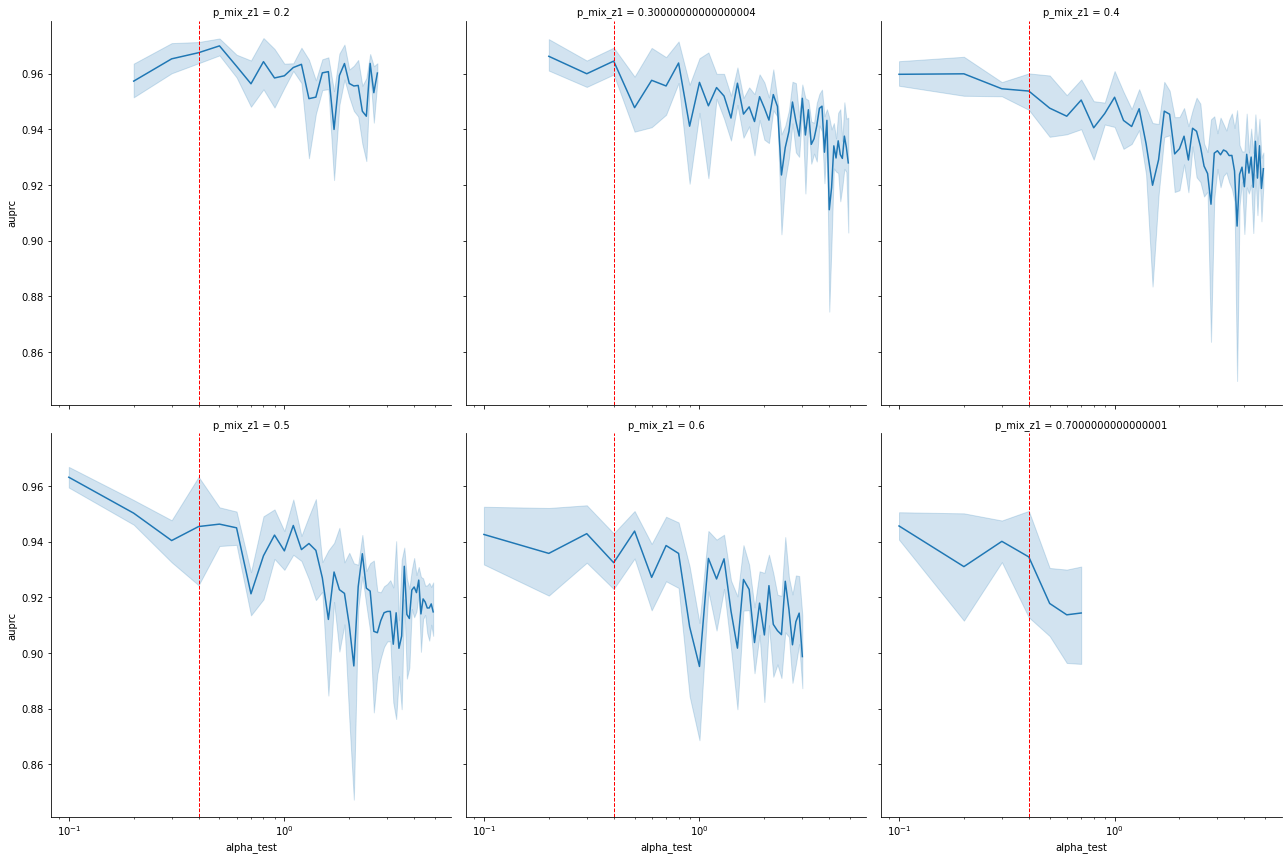

In [13]:
# plt.figure(figsize=(10,10))

g = sns.FacetGrid(df, col="p_mix_z1", col_wrap=3, height=6)

g.map_dataframe(sns.lineplot, x="alpha_test", y="auprc")

g.map(plt.axvline, x=0.4, ls='--', c='red', linewidth=1)

g.set(ylabel="auprc")
plt.xscale('log')


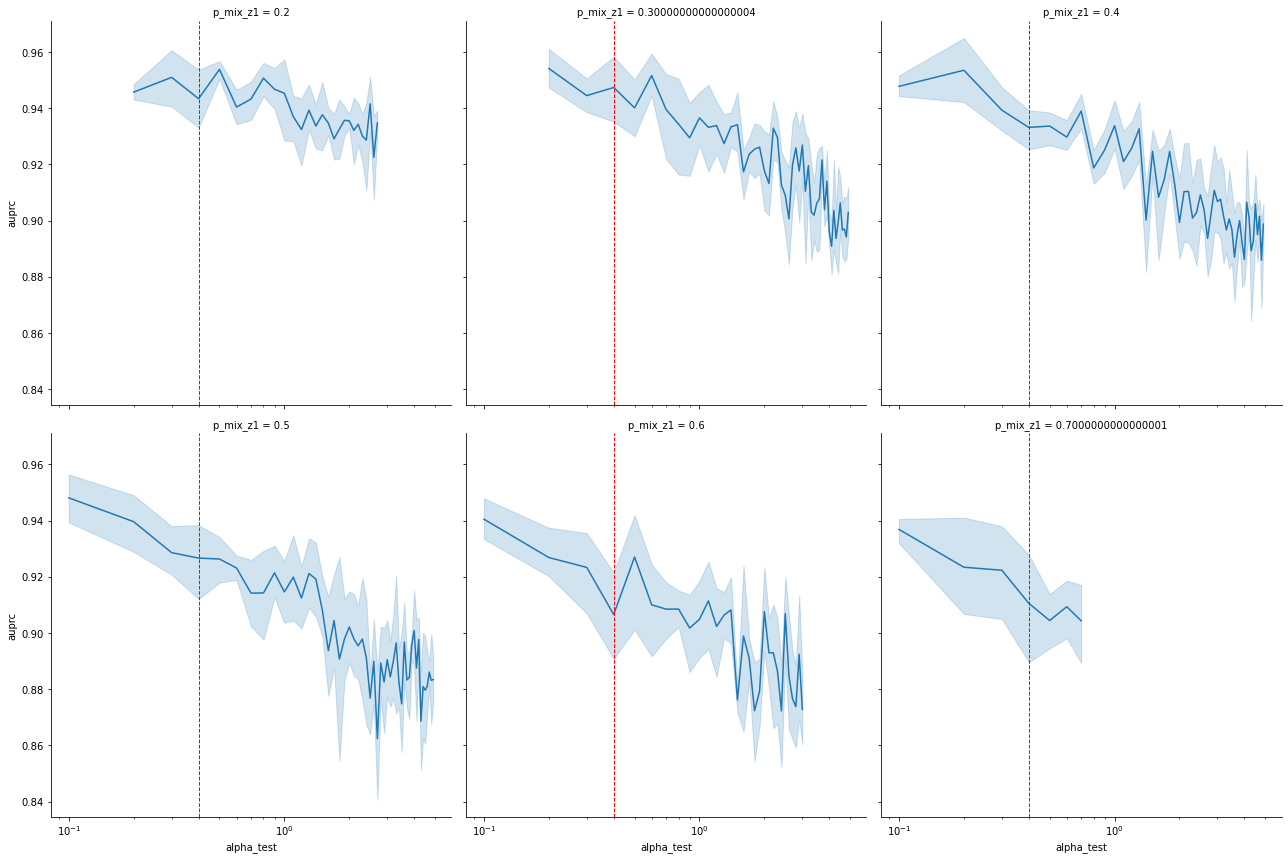

In [58]:
# plt.figure(figsize=(10,10))

g = sns.FacetGrid(df, col="p_mix_z1", col_wrap=3, height=6)

g.map_dataframe(sns.lineplot, x="alpha_test", y="auprc")

g.map(plt.axvline, x=0.4, ls='--', c='red', linewidth=1)

g.set(ylabel="auprc")
plt.xscale('log')


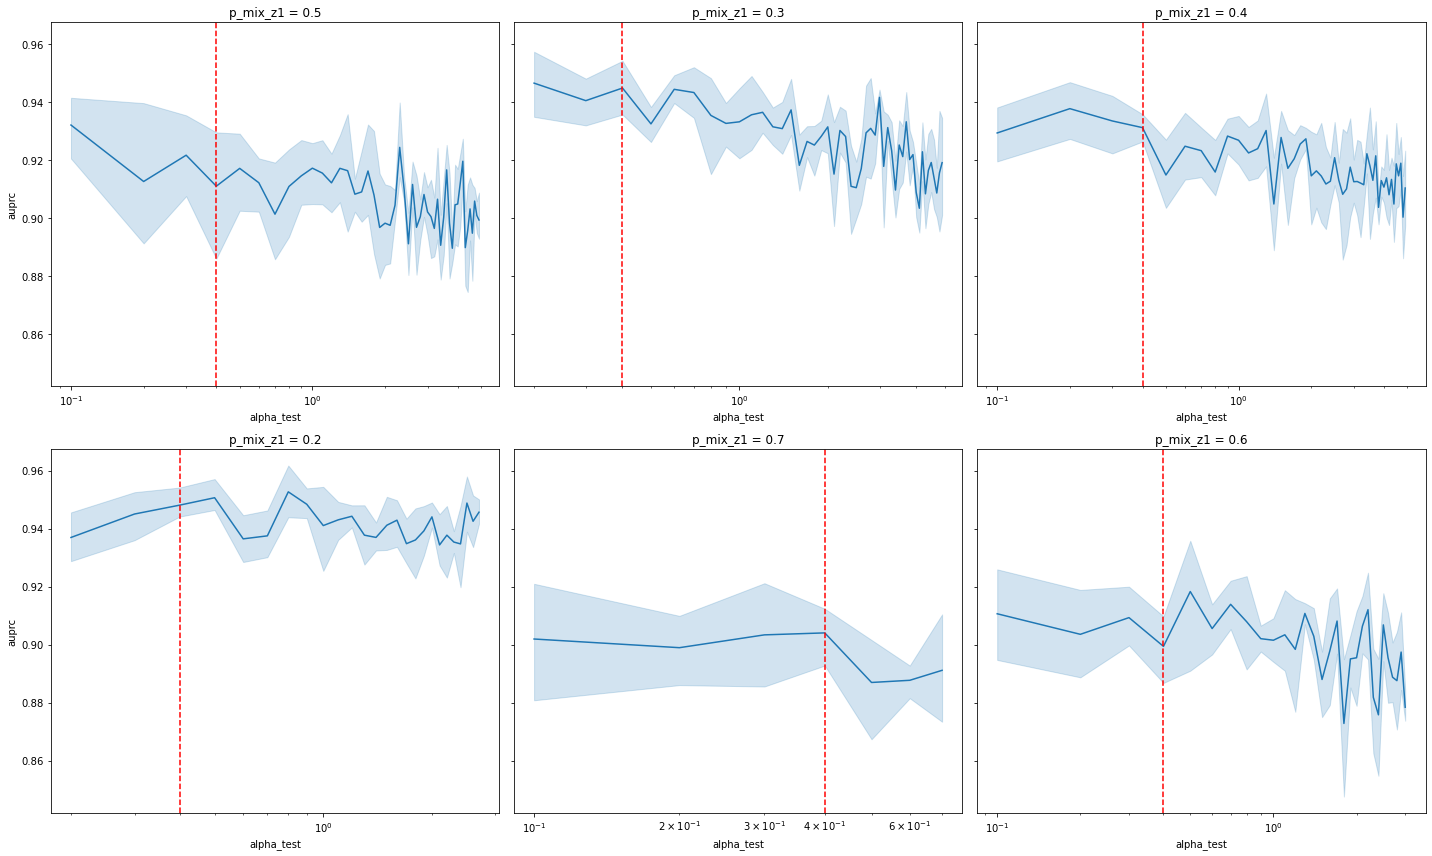

In [16]:
p_mix_z1 = df['p_mix_z1'].unique()
x = "alpha_test"

vline = 0.4

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = x
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx])
    
    if vline:
        ax[idx].axvline(vline, color="red", linestyle="--")
        
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].set_xscale('log')

plt.tight_layout()


# Merge Two (or more) datasets

In [35]:
df_dict={}

In [36]:

path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_n500_05_02/"]
y_pred_file = None
y_pred_file = "y_pred.csv"
y_prob_file = "y_prob.csv"

nm = "vanilla BERT"


df = collectResults(path_results=path_results, y_prob_file=y_prob_file, y_test_file=y_test_file, y_pred_file=y_pred_file)
df_dict[nm] = df

In [37]:

path_results = ["../output/step104_runExp_backdoorBERT_SHAC/exp_backdoorBERT_SHAC_n500_05_02_v1/"]
y_pred_file = None
y_prob_file = "y_main_prob.csv"
y_test_file = "y_test.csv"

nm = "backdoor BERT"

df = collectResults(path_results=path_results, y_prob_file=y_prob_file, y_test_file=y_test_file, y_pred_file=y_pred_file)
df_dict[nm] = df

In [38]:

path_results = ["../output/step105_runExp_SingleLabel_UID_SHAC/exp_SingleHead_UID_SHAC_n500_05_02/"]
y_pred_file = None
y_prob_file = "y_prob.csv"
y_test_file = "y_test.csv"

nm = 'BERT w UID'

df = collectResults(path_results=path_results, y_prob_file=y_prob_file, y_test_file=y_test_file, y_pred_file=y_pred_file)
df_dict[nm] = df

In [39]:
v

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Train_Test,auprc,f1_at_05,run,test_loss
0,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.910695,0.821429,1,0.303084
1,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.898336,0.804805,2,0.324922
2,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.897670,0.822485,3,0.316889
3,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.911448,0.812325,4,0.324047
4,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.903962,0.803625,0,0.321791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.896098,0.819338,1,0.356029
1041,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.931803,0.848921,2,0.312090
1042,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.907000,0.815385,3,0.378775
1043,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.934380,0.837438,4,0.301409


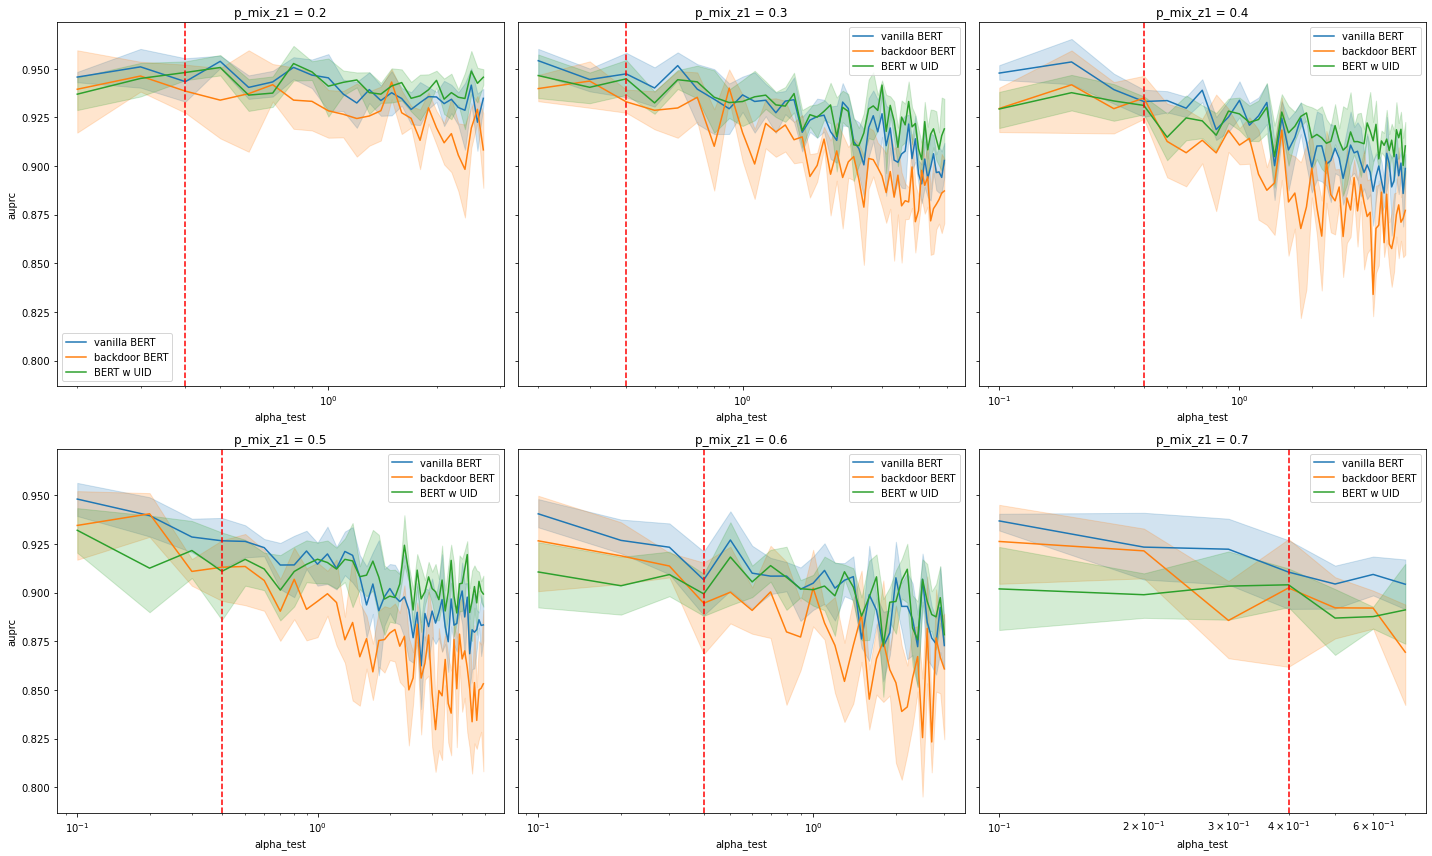

In [41]:
p_mix_z1 = sorted(df_dict['vanilla BERT']['p_mix_z1'].unique())
# p_mix_z1 = [0.2,0.3,0.4,0.5,0.6,0.7]
x = "alpha_test"

vline = 0.4

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = x
    
    for dfName,v in df_dict.items():
    
        _df = v[v['p_mix_z1'] == k].sort_values(xlabel)
        sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx], label=dfName)
    
    if vline:
        ax[idx].axvline(vline, color="red", linestyle="--")
        
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].set_xscale('log')

plt.tight_layout()

In [42]:
df

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Train_Test,auprc,f1_at_05,run,test_loss
0,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.910695,0.821429,1,0.303084
1,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.898336,0.804805,2,0.324922
2,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.897670,0.822485,3,0.316889
3,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.911448,0.812325,4,0.324047
4,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.21875,0.481250,0.35,0.5,0.361134,0.903962,0.803625,0,0.321791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.896098,0.819338,1,0.356029
1041,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.931803,0.848921,2,0.312090
1042,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.907000,0.815385,3,0.378775
1043,0.5,0.2,0.41,0.41,0.7,0.3,0.4,4.4,0.20297,0.893069,0.41,0.3,1.528308,0.934380,0.837438,4,0.301409


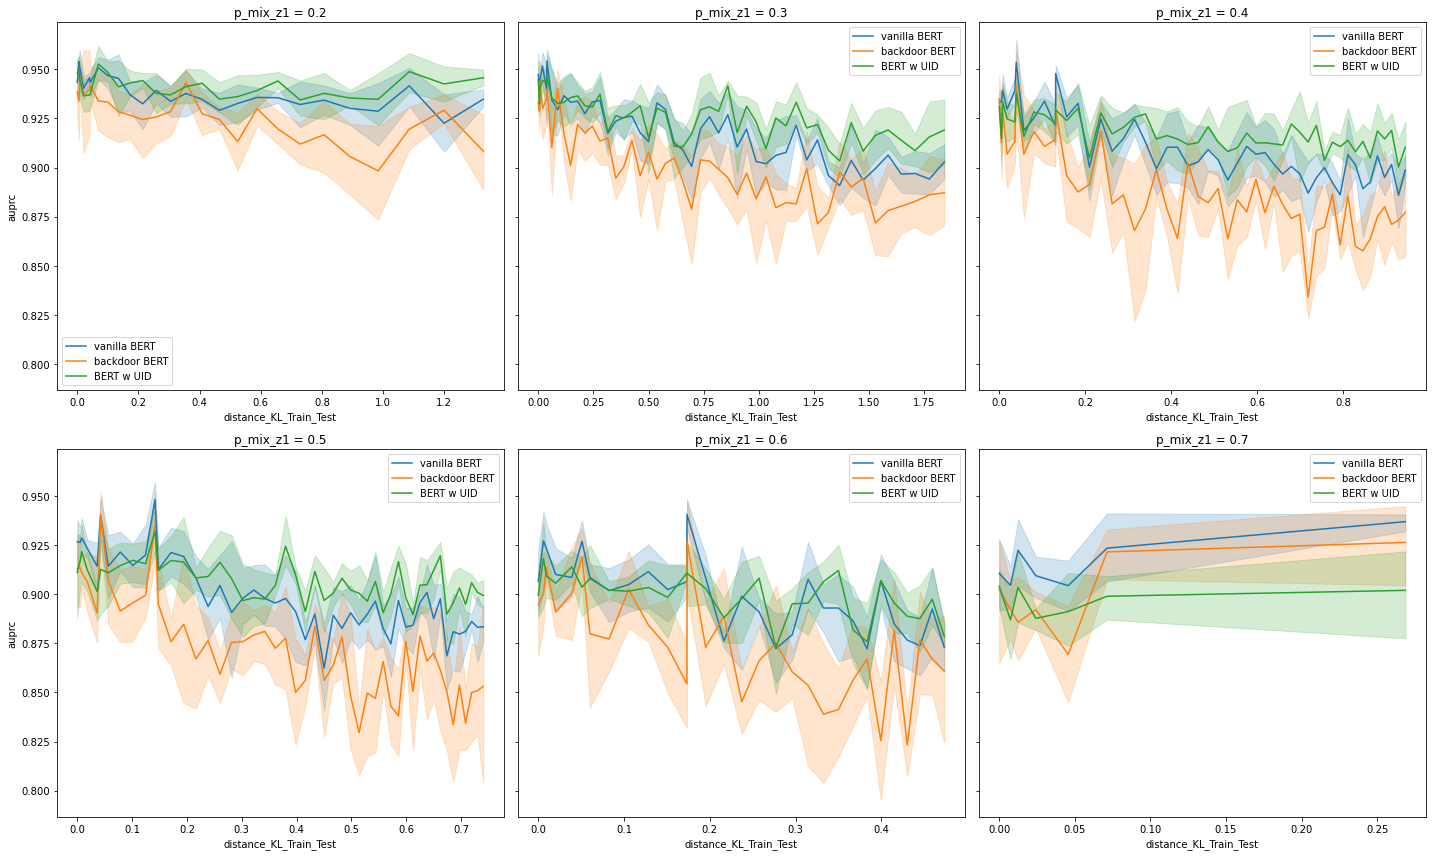

In [44]:
p_mix_z1 = sorted(df_dict['vanilla BERT']['p_mix_z1'].unique())
# x = "alpha_test"
x = "distance_KL_Train_Test"

vline = None

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = x
    
    for dfName,v in df_dict.items():
    
        _df = v[v['p_mix_z1'] == k].sort_values(xlabel)
        sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx], label=dfName)
    
    if vline:
        ax[idx].axvline(vline, color="red", linestyle="--")
        
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    # ax[idx].set_xscale('log')

plt.tight_layout()

In [58]:
sorted(df_dict['vanilla BERT']['p_mix_z1'].unique())

[0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001]

In [69]:
ax

<AxesSubplot:>

In [ ]:
p_mix_z1 = sorted(df_dict['vanilla BERT']['p_mix_z1'].unique())
# p_mix_z1 = [0.3]

# x = "alpha_test"
x = "distance_KL_Train_Test"

vline = None

fig, ax = plt.subplots(1,2, figsize=(20,12), sharey=True, squeeze=False)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    if round(k,2) == 0.3: 
        xlabel = x

        for dfName,v in df_dict.items():

            if dfName in ["vanilla BERT", "backdoor BERT"]:
                _df = v[v['p_mix_z1'] == k].sort_values(xlabel)
                sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx], label=dfName)

        if vline:
            ax[idx].axvline(vline, color="red", linestyle="--")

        # ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
        ax[idx].set_xlabel(f"KL Divergence")
        # ax[idx].set_xscale('log')

plt.tight_layout()

In [79]:
_x = np.arange(0,2,0.2)

In [86]:
_y

array([0.99, 0.97, 0.95, 0.93, 0.91, 0.89, 0.87, 0.85, 0.83, 0.81, 0.79,
       0.77, 0.75, 0.73, 0.71])

In [85]:
_y = np.arange(0.99,0.7,-0.02)

<AxesSubplot:>

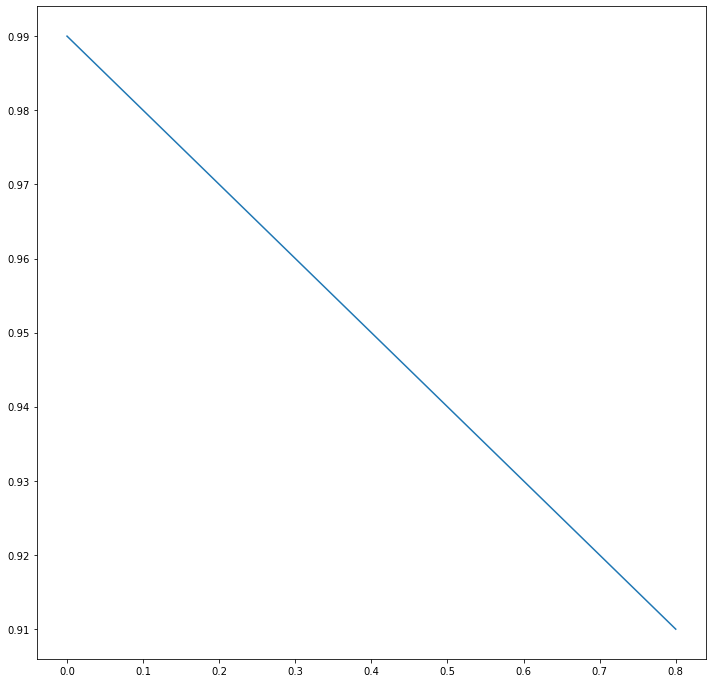

In [88]:
fig, ax = plt.subplots(1,1, figsize=(12,12), sharey=True, squeeze=False)

sns.lineplot(x=_x[:5], y=_y[:5], )


# Check Loss

In [49]:
df_ls = []

for path_i in pathlib.Path(path_results[0]).glob("setting*"):
    
    with open(pathlib.Path(path_i, "full_settings.pkl"), "br") as f:
        full_setting_i = pickle.load(f)
        
    for rand_i in path_i.glob("RandomRun_*"):
        
        
        _df = pd.read_csv(pathlib.Path(rand_i, "loss_epoch_avg.csv")).reset_index()
        _df.rename({"index":"epoch_num"}, axis=1, inplace=True)
        _df["epoch_num"] = _df["epoch_num"] + 1
        num_i = os.path.basename(rand_i).split("_")[1]
        
        y_pred = pd.read_csv(pathlib.Path(rand_i, "y_pred.csv"))
        y_prob = pd.read_csv(pathlib.Path(rand_i, "y_prob.csv"))
        y_test = pd.read_csv(pathlib.Path(rand_i, "y_test.csv"))

        _dfSetting = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient = 'index').T        
        _dfSetting['run'] = int(num_i)
        
        for col_i in _dfSetting.columns:
            _df[col_i] = _dfSetting[col_i].values[0]
            
        
        

        
    
        df_ls.append(_df)

In [51]:
df_loss_epoch_avg = pd.concat(df_ls).reset_index(drop=True)

In [53]:
df_loss_epoch_avg

,epoch_num,loss_epoch_avg,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,run
0,1,0.641346,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
1,2,0.619577,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
2,3,0.559880,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
3,4,0.503103,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
4,5,0.460618,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2,0.623703,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5996,3,0.573736,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5997,4,0.511493,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5998,5,0.485128,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0


In [52]:
g = sns.FacetGrid(df_loss_epoch_avg, col="run", row="alpha_test")

g.map_dataframe(sns.lineplot, x="epoch_num", y="loss_epoch_avg")

# g.map(plt.axhline, y=df['test_loss'], ls='--', c='red', linewidth=1)

# g.set(ylabel="auprc")




KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb89ecc1d30> (for post_execute):



KeyboardInterrupt



In [95]:
from sklearn.model_selection import train_test_split
import random

In [102]:
np.random.random()

0.16990016479895875

In [117]:
tmp_train, tmp_test = train_test_split(df, train_size=10,
                                       test_size=5,
                                       shuffle = True, random_state=2023)

In [109]:
tmp_train.index

Int64Index([226, 100, 426, 815, 836, 338, 669, 743, 912, 320], dtype='int64')

In [112]:
tmp_train.index

Int64Index([815, 836, 338, 669, 743, 912, 320, 843, 796, 322], dtype='int64')

In [115]:
tmp_train.index

Int64Index([338, 669, 743, 912, 320, 843, 796, 322, 261, 136], dtype='int64')

In [118]:
tmp_train.index

Int64Index([138, 49, 226, 100, 426, 815, 836, 338, 669, 743], dtype='int64')

In [110]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49], dtype='int64')

In [113]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49, 226, 100, 426], dtype='int64')

In [116]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49, 226, 100, 426, 815, 836], dtype='int64')

In [119]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764], dtype='int64')

In [144]:
tmp_train, tmp_test = train_test_split(df, train_size=15,
                                       test_size=50,
                                       shuffle = True, random_state=100)

In [145]:
tmp_train.index

Int64Index([173, 828, 378, 310, 222, 43, 704, 542, 745, 244, 61, 543, 512, 24,
            547],
           dtype='int64')

In [146]:
tmp_test.index

Int64Index([249, 353, 537, 424, 564, 124, 492, 553, 982, 935, 633, 771, 146,
            672, 727, 395, 330, 923, 315, 629, 956, 216, 930,  44, 116, 639,
            879,  48, 562, 781, 949, 178, 197, 266, 312, 737, 751, 717, 164,
            467, 171, 155, 221, 489, 688, 229, 580, 118, 888, 480],
           dtype='int64')

In [147]:
tmp_train, tmp_test = train_test_split(df, train_size=12,
                                       test_size=40,
                                       shuffle = True, random_state=100)

In [148]:
tmp_train.index

Int64Index([171, 155, 221, 489, 688, 229, 580, 118, 888, 480, 173, 828], dtype='int64')

In [149]:
tmp_test.index

Int64Index([249, 353, 537, 424, 564, 124, 492, 553, 982, 935, 633, 771, 146,
            672, 727, 395, 330, 923, 315, 629, 956, 216, 930,  44, 116, 639,
            879,  48, 562, 781, 949, 178, 197, 266, 312, 737, 751, 717, 164,
            467],
           dtype='int64')